# Wotan: Basic functionality

To illustrate the easiest use case, we generate some noisey synthetic data which includes *signals* we hope to preserve:

In [1]:
import numpy as np
points = 1000
time = np.linspace(0, 15, points)
flux = 1 + ((np.sin(time) +  + time / 10 + time**1.5 / 100) / 1000)
noise = np.random.normal(0, 0.0001, points)
flux += noise
for i in range(points):  
    if i % 75 == 0:
        flux[i:i+5] -= 0.0004  # Add some transits
        flux[i+50:i+52] += 0.0002  # and flares
flux[400:500] = np.nan  # a data gap

Use wotan to detrend:

In [2]:
from wotan import flatten
flatten_lc, trend_lc = flatten(time, flux, window_length=0.5, return_trend=True)

Plot the result:

<IPython.core.display.Javascript object>


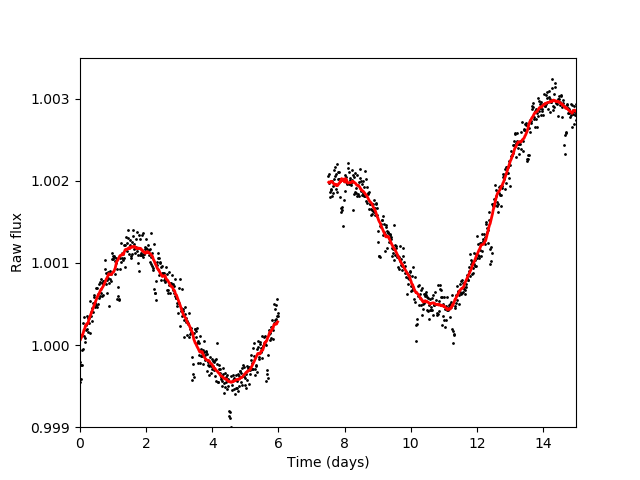

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.rcParams["figure.dpi", ] = 150
#plt.rcParams['figure.figsize'] = [5, 3]

plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc, linewidth=2, color='red')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.xlim(0, 15)
plt.ylim(0.999, 1.0035);
plt.show();

To show the detrended lightcurve, we could of course divide the raw flux by the red trend line. As wotan provides this directly as ``flatten_lc``, we can just plot that:

<IPython.core.display.Javascript object>


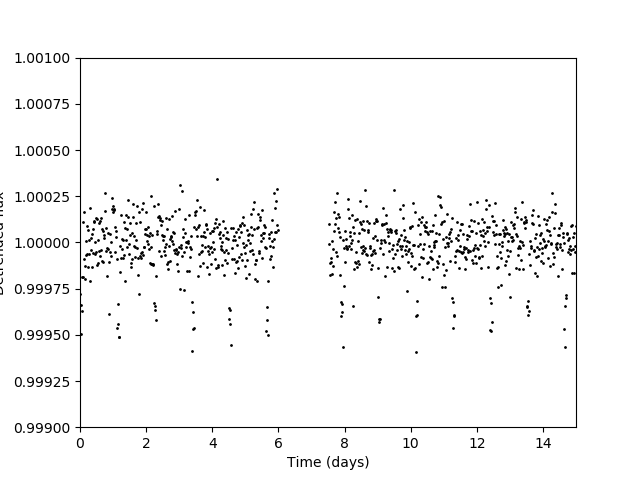

In [15]:
plt.close()
plt.scatter(time, flatten_lc, s=1, color='black')
plt.xlim(0, 15)
plt.ylim(0.999, 1.001)
plt.xlabel('Time (days)')
plt.ylabel('Detrended flux')
plt.show();

## Using ``window_length`` to find the right balance between overfitting and underfitting

So far, we used ``window_length=0.5`` without justification. We can explore other window sizes:

<IPython.core.display.Javascript object>


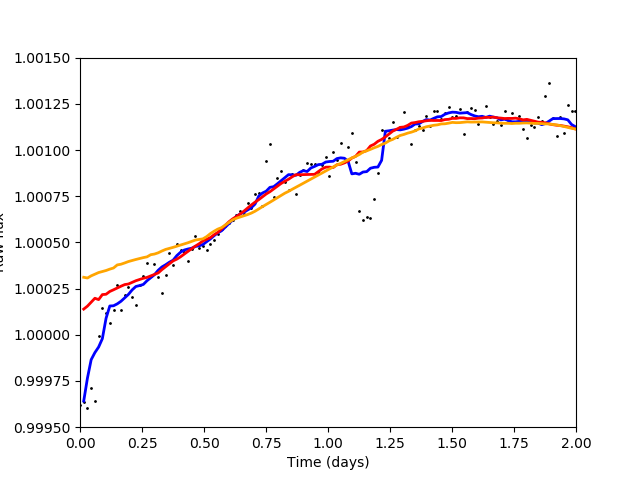

In [21]:
flatten_lc1, trend_lc1 = flatten(time, flux, window_length=0.2, return_trend=True)
flatten_lc2, trend_lc2 = flatten(time, flux, window_length=0.5, return_trend=True)
flatten_lc3, trend_lc3 = flatten(time, flux, window_length=1,   return_trend=True)
plt.close()
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, linewidth=2, color='blue')  # overfit
plt.plot(time, trend_lc2, linewidth=2, color='red')  # about right
plt.plot(time, trend_lc3, linewidth=2, color='orange')  # underfit
plt.xlim(0, 2)
plt.ylim(0.9995, 1.0015)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

- We can see that the shortest (blue) trend with ``window_length=0.2`` produces an *overfit*. This is visible near ``t=1.25`` where part of the transit signal is removed.
- The red trend line (``window_length=0.5``) seems about right
- The orange trend line (``window_length=1``) is probably an underfit, because it doesn't readily adjust near the beginning of the time series.

## Remove edges

Is the feature right at the start a signal that we want to keep?. A visual examination is inconclusive. For the purpose of a blind transit search, it is (slightly) preferable to remove edges. We can do this with wotan:

<IPython.core.display.Javascript object>


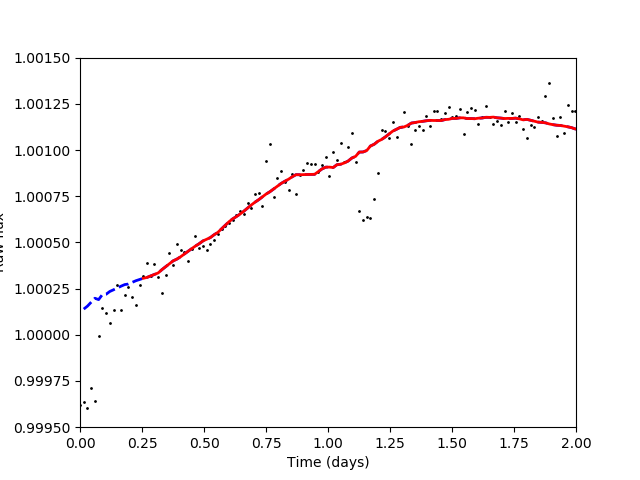

In [22]:

flatten_lc1, trend_lc1 = flatten(time, flux, window_length=0.5, return_trend=True)
flatten_lc2, trend_lc2 = flatten(time, flux, window_length=0.5, edge_cutoff=0.5, return_trend=True)
plt.close()
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc1, linewidth=2, color='blue', linestyle='dashed')
plt.plot(time, trend_lc2, linewidth=2, color='red')
plt.xlim(0, 2)
plt.ylim(0.9995, 1.0015)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

Note that we set ``edge_cutoff=0.5``, but only 0.25 are removed -- the maximum is half a window length, because for anything longer than that, the window is fully filled and thus the trend is optimal.

## Handling gaps in the data

If there are large gaps in time, especially with corresponding flux level offsets, the detrending is often much improved when splitting the data into several sub-lightcurves and applying the filter to each segment individually. The default setting for a break is ``window_length/2``.

The feature can be disabled with ``break_tolerance=0``. Then, the whole dataset is treated as one.

Positive values, e.g., ``break_tolerance=0.1``, split the data into chunks if there are breaks longer than 0.1 days (which is the case here):

<IPython.core.display.Javascript object>


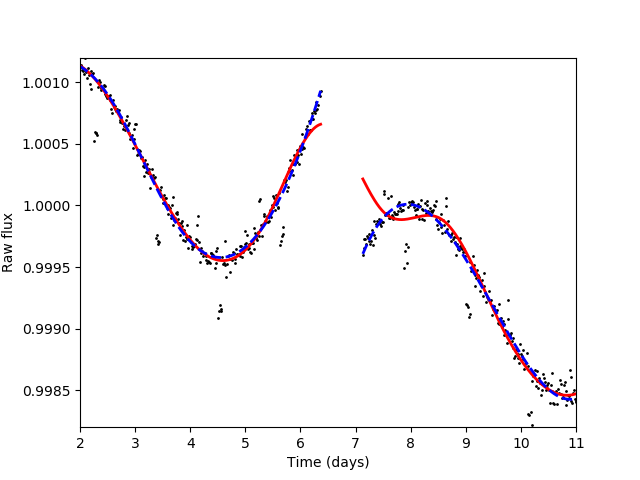

In [24]:
points = 1000
time = np.linspace(0, 15, points)
flux = 1 + ((np.sin(time) +  + time / 10 + time**1.5 / 100) / 1000)
noise = np.random.normal(0, 0.00005, points)
flux += noise
for i in range(points):  
    if i % 75 == 0:
        flux[i:i+5] -= 0.0004  # Add some transits
        flux[i+50:i+52] += 0.0002  # and flares
flux[425:475] = np.nan  # a data gap
flux[475:] -= 0.002
flatten_lc1, trend_lc1 = flatten(time, flux, break_tolerance=0.1, window_length=1, method='hspline', return_trend=True)
flatten_lc2, trend_lc2 = flatten(time, flux, break_tolerance=0,   window_length=1, method='hspline', return_trend=True)

plt.close()
plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc2, linewidth=2, color='red')
plt.plot(time, trend_lc1, linewidth=2, color='blue', linestyle='dashed')
plt.xlim(2, 11)
plt.ylim(0.9982, 1.0012)
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.show();

Here, the blue trend uses segments, whereas the red trend tries to make it in one go - and fails.
Usually, splines are much more sensitive to offets than slider-based detrenders.
In this case, the spline is much improved if segments are used (``break_tolerance>0``)